In [234]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pandas_datareader as web

from collections import Counter
import pickle

from xgboost import XGBClassifier

In [235]:
from bokeh.plotting import figure,output_file, show
from bokeh.layouts import column
from bokeh.embed import components
from bokeh.models import ColumnDataSource, DatetimeTickFormatter, Legend, Title, Arrow, HoverTool
from bokeh.io import output_notebook
#output_notebook()

In [236]:
bull_xgb_rcv = pickle.load(open('models/bull_xgb_rcv1.pickle', 'rb'))
bear_xgb_rcv = pickle.load(open('models/bear_xgb_rcv2.pickle', 'rb'))

In [237]:
def create_pred_df(ticker):
    pred_start = pd.datetime.today() - pd.to_timedelta(200, unit='day') 
    pred_end = pd.datetime.today()
    
    bull_columns = ['Returns', 'Unemployment Rate', 'Inflation Rate', 'Misery Index',
       'local_price', 'Bullish', 'Neutral', 'Bearish', 'EMA12_pctchg', 'RSI',
       'Pct_Chg', 'MACD_sentiment', 'Upper_BB_pctchg', 'Lower_BB_pctchg',
       'EMA_sentiment', 'Volume_sentiment']

    bear_columns = ['Bearish', 'Bullish', 'Neutral', 'Returns', 'Inflation Rate',
       'Lower_BB_pctchg', 'Unemployment Rate', 'Upper_BB_pctchg']
    
    df = web.DataReader(ticker, 'yahoo', pred_start, pred_end)

    adv_stock_indicators(df)

    df['MACD_sentiment'] = list(map(classify_bullish, df['MACD'], df['MACD_Signal']))
    df['EMA_sentiment'] = list(map(classify_bullish, df['EMA26'], df['EMA12']))
    df['Volume_sentiment']  = list(map(classify_bullish, df['Dollar_volume'], df['Rolling_Dollar_volume']))
    
    alternative_data = pd.read_csv('data/cleaned_alternative_data.csv')
    alternative_data['Date'] = pd.to_datetime(alternative_data['Date'])
    alternative_data.set_index('Date', inplace=True)
    
    full_df = alternative_data.join(df).dropna()

    #Predict buy signals
    full_df['buy_probabilities'] = bull_xgb_rcv.predict_proba(full_df[bull_columns])[:,1]
    full_df['buy_predictions'] = full_df['buy_probabilities'] >= full_df['buy_probabilities'].mean()

    #Predict sell signals
    full_df['sell_probabilities'] = bear_xgb_rcv.predict_proba(full_df[bear_columns])[:,1]
    full_df['sell_predictions'] = full_df['sell_probabilities'] >= full_df['sell_probabilities'].mean()
     
    return full_df

def adv_stock_indicators(df):
    df.reset_index()
    #Simple Moving Averages
    df['SMA12'] = df['Close'].rolling(12).mean()
    df['SMA26'] = df['Close'].rolling(26).mean()

    #Exponential Moving Averages
    df['EMA12'] = df['Close'].ewm(span=12).mean()
    df['EMA26'] = df['Close'].ewm(span=26).mean()

    #Using absolute as difference
    df['SMA12_pctchg'] = abs(((df['Close'] - df['SMA12']) / df['SMA12']) * 100) 
    df['SMA26_pctchg'] = abs(((df['Close'] - df['SMA26']) / df['SMA26']) * 100)
    df['EMA12_pctchg'] = abs(((df['Close'] - df['EMA12']) / df['EMA12']) * 100) 
    df['EMA26_pctchg'] = abs(((df['Close'] - df['EMA26']) / df['EMA26']) * 100) 

    #RSI using EMA
    #Default window length: 14
    delta = df['Close'].diff()
    window_length = 14

    up = delta.copy()
    up[delta<=0]=0.0
    down = abs(delta.copy())
    down [delta>0]=0.0

    RS_up = up.ewm(window_length).mean()
    RS_down = down.ewm(window_length).mean()

    rsi= 100-100/(1+RS_up/RS_down)
    df['RSI'] = rsi

    #MACD
    #Default: Fast Length=EMA12, Slow Length=EMA26, MACD Length=EMA9
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Adj Close'].ewm(span=26).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()

    #Percent Change
    df['Pct_Chg'] = df['Close'].pct_change() * 100
    
    #Bollinger Bands
    df['Upper_BB'] = df['Close'].rolling(window=20).mean() + (df['Close'].rolling(window=20).std() * 2)
    df['Upper_BB_pctchg'] = abs(((df['Close'] - df['Upper_BB']) / df['Upper_BB']) * 100)

    df['Lower_BB'] = df['Close'].rolling(window=20).mean() - (df['Close'].rolling(window=20).std() * 2)
    df['Lower_BB_pctchg'] = abs(((df['Close'] - df['Lower_BB']) / df['Lower_BB']) * 100)
    
    df['Range_BB'] = (df['Upper_BB'] - df['Lower_BB']) / df['Lower_BB'] * 100
    
    #Candlestick Range
    df['Candlestick_range'] = (df['High'] - df['Low']) / df['Low'] * 100
    
    #Dollar Volume
    df['Dollar_volume'] = df['Close'] * df['Volume']
    df['Rolling_Dollar_volume'] = df['Dollar_volume'].rolling(10).mean()

    df.dropna(inplace=True)

def classify_bullish(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0
    
def classify_bearish(current, future):
    if float(future) < float(current):
        return 1
    else:
        return 0

In [246]:
def predict_ticker(ticker):
    predict_df = create_pred_df(ticker)
    
    df1 = predict_df

    inc = df1['Close'] > df1['Open']
    dec = df1['Open'] > df1['Close']
    w = 12*60*60*1000

    p = figure(title= f'{ticker}'+ ' Chart\n', 
               sizing_mode = 'stretch_both',
               #x_axis_label='Date', 
               y_axis_label='Price (USD)',
               y_range=(min(df1['Close'])/1.20, max(df1['High'])*1.10))

    
    #background
    p.background_fill_color = "white"
    p.background_fill_alpha = 0.5

    #gridlines    
    p.xgrid.minor_grid_line_color = 'navy'
    p.xgrid.minor_grid_line_alpha = 0.05
    p.ygrid.minor_grid_line_color = 'navy'
    p.ygrid.minor_grid_line_alpha = 0.05

    #title
    p.title.text_font_size = '30pt'
    p.title.align = 'center'
    
    if df1.tail(1)['buy_predictions'].values[0] == True:
        p.add_layout(Title(
            text= "10-Day Predictions for "+ f"{df1.tail(1).index[0].strftime('%m/%d/%Y')}: " + "BUY" 
            , text_font_size="16pt"), 'above') 
    elif df1.tail(1)['sell_predictions'].values[0] == True:
        p.add_layout(Title(
            text= "10-Day Predictions for "+ f"{df1.tail(1).index[0].strftime('%m/%d/%Y')}: " + "SELL" 
            , text_font_size="16pt"), 'above')
    else:
        p.add_layout(Title(
            text= "10-Day Predictions for "+ f"{df1.tail(1).index[0].strftime('%m/%d/%Y')}: " + "UNCERTAIN" 
            , text_font_size="16pt"), 'above')
        
    #axes
    p.xaxis.axis_label_text_font_size = "13pt"
    p.yaxis.axis_label_text_font_size = "13pt"
    p.xaxis.formatter=DatetimeTickFormatter(days="%m/%d")
    p.xaxis.ticker.desired_num_ticks=30
    p.xaxis.major_label_orientation = "vertical"

    #Candlestick
    p.segment(df1.index, df1['High'], df1.index, df1['Low'], color='black')
    p.vbar(df1.index[inc], w, df1['Open'][inc], df1['Close'][inc], fill_color='green', line_color='black')
    p.vbar(df1.index[dec], w, df1['Open'][dec], df1['Close'][dec], fill_color='red', line_color='black')

    #EMA
    e12 = p.line(df1.index, df1['EMA12'], line_color='darkorange', line_dash='dotted', alpha=0.90)
    e26 = p.line(df1.index, df1['EMA26'], line_color='navy', line_dash='dotted', alpha=0.90)

    #BBs
    bb = p.line(df1.index, df1['Upper_BB'], line_color='black', line_dash='solid', alpha=0.50)
    p.line(df1.index, df1['Lower_BB'], line_color='black', line_dash='solid', alpha=0.50)

    #ML Prediction
    buy_ml = p.circle(df1.index, (df1['Low']*df1['buy_predictions']) - (df1['Low'] * 0.05), size=7, color='darkgreen', fill_alpha=0.50)
    sell_ml = p.circle(df1.index, (df1['High']*df1['sell_predictions']) + (df1['High'] * 0.05), size=7, color='darkred', fill_alpha=0.50)

    #Volume
    bar = figure(
                width=1000, height=100,
                y_axis_label='Volume')
    bar.yaxis.axis_label_text_font_size = "13pt"
    bar.xaxis.formatter=DatetimeTickFormatter()
    bar.xaxis.ticker.desired_num_ticks=10
    bar.vbar(df1.index, top = df1['Volume']/1000000, width=10)

    #RSI 
    p2 = figure(
                width=1000, height=125,
                x_axis_label='Date',
                y_axis_label='RSI')
    p2.yaxis.axis_label_text_font_size = "13pt"
    p2.xaxis.axis_label_text_font_size = "13pt"

    p2.xaxis.formatter=DatetimeTickFormatter()
    p2.xaxis.ticker.desired_num_ticks=10
    p2.line(df1.index, df1['RSI'], line_color='orange')
    p2.line(df1.index, 70, line_color='gray', line_dash='dashed')
    p2.line(df1.index, 30, line_color='gray', line_dash='dashed')

    show(column(p, bar, p2))
    
    return predict_df[['buy_predictions','buy_probabilities', 'sell_predictions', 'sell_probabilities']]

In [247]:
tickers = ['SPY']
for tick in tickers:
    predictions = predict_ticker(tick)

In [248]:
predictions.tail(20)

,buy_predictions,buy_probabilities,sell_predictions,sell_probabilities
Date,,,,
2020-11-09,True,0.828534,False,0.034934
2020-11-10,True,0.774227,False,0.034934
2020-11-11,True,0.828378,False,0.034934
2020-11-12,True,0.852016,False,0.042048
2020-11-13,True,0.788554,False,0.042048
2020-11-16,True,0.752230,False,0.042048
2020-11-17,True,0.759092,False,0.042048
2020-11-18,True,0.834213,False,0.042048
2020-11-19,False,0.530970,True,0.114297


In [249]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import seaborn as sns

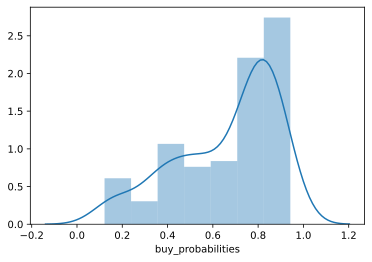

In [250]:
sns.distplot(predictions['buy_probabilities'])
plt.show()

In [251]:
print("Sell Median: ", predictions['buy_probabilities'].median())
print("Sell Mean: ", predictions['buy_probabilities'].mean())

Sell Median:  0.7556611
Sell Mean:  0.659077


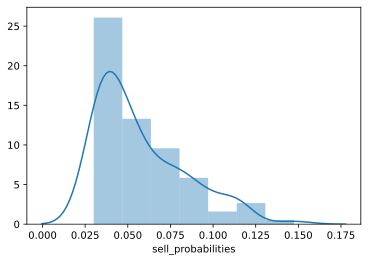

In [244]:
sns.distplot(predictions['sell_probabilities'])
plt.show()

In [245]:
print("Sell Median: ", predictions['sell_probabilities'].median())
print("Sell Mean: ", predictions['sell_probabilities'].mean())

Sell Median:  0.048873715
Sell Mean:  0.05742119
